# 实验四：朴素贝叶斯分类器

> 姓名：王茂增\
学号：2113972\
专业：计算机科学与技术\
代码：https://github.com/mzwangg/MachineLearning

- 基本要求
    - 采用分层采样的方式将数据集划分为训练集和测试集。 
    - 给定编写一个朴素贝叶斯分类器，对测试集进行预测，计算分类准确率。
- 中级要求：
    - 使用测试集评估模型，得到混淆矩阵，精度，召回率，F值。
- 高级要求：
    - 在中级要求的基础上画出三类数据的ROC曲线，并求出AUC值。
- 拓展要求：
    - 浅谈ROC曲线和AUC值作为分类评价的合理性。


## 导入需要的包

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

1. 为了实验的可复现性，设置随机数种子
1. 忽略警告信息，使其不显示在控制台上。
2. 设置Matplotlib的字体为宋体（SimHei），以显示中文字符。
3. 设置Matplotlib不显示负号为Unicode字符，以确保正确显示负号。

In [2]:
np.random.seed(0)# 为了实验的可复现性，设置随机数种子
warnings.filterwarnings("ignore") # 不显示warning
plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 显示负号

进行标准化或归一化

In [3]:
def standardize_data(data):
    # 计算均值和标准差
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    # 防止除以零的情况，如果某列的标准差为0，将其替换为1
    std[std == 0] = 1
    # 标准化数据
    data = (data - mean) / std
    return data

def normalization_data(data):
    # 计算均值、最大值、最小值
    mean = np.mean(data, axis=0)
    max = np.max(data, axis=0)
    min = np.min(data, axis=0)
    # 防止除以零的情况，如果某列的标准差为0，将其替换为1
    max[max == min] = min[max == min] + 1
    # 归一化数据
    data = (data - mean) / (max - min)
    return data

读取数据，进行标准化，并分别存储各类别的数据

In [4]:
data = np.genfromtxt('wine.data', delimiter=',')# 读取数据
X = data[:, 1:] # 特征
y = data[:, 0] # 标签
X = standardize_data(X) # 进行数据标准化

data_num = len(X)
class_num = 3
X_list = [X[y == i + 1] for i in range(class_num)]

标准化结果可视化

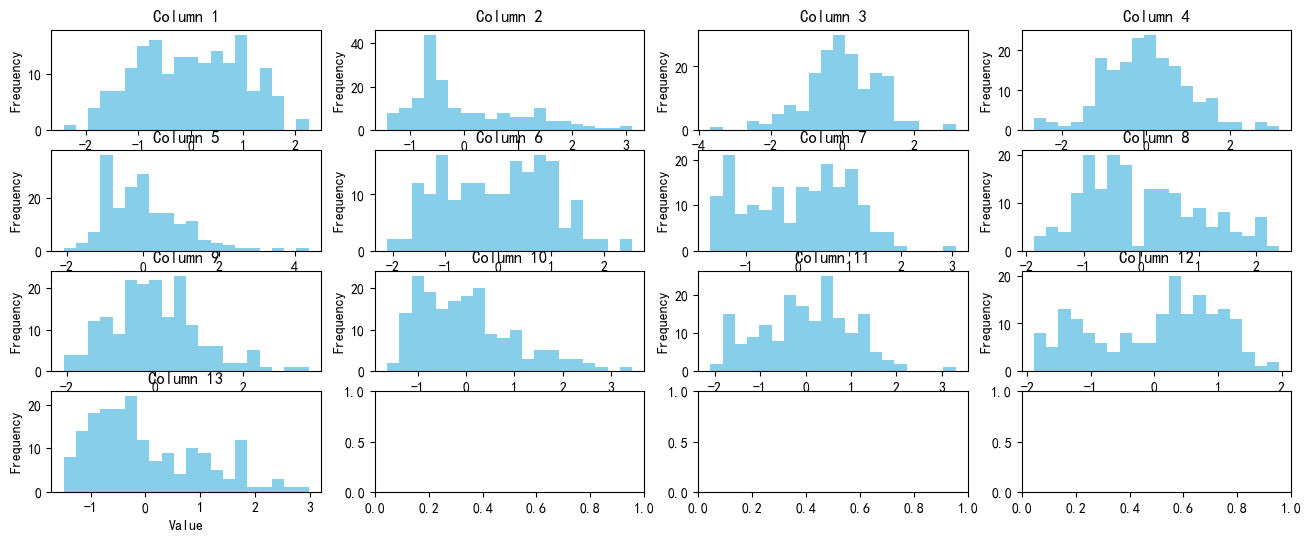

In [5]:
# 创建子图，以 3 行 4 列的方式排列直方图
_, axes = plt.subplots(4, 4, figsize=(16, 6))
# 将二维子图数组展平，以便遍历
axes = axes.ravel()
# 遍历列，并绘制直方图
for i in range(X.shape[1]):
    ax = axes[i]
    ax.hist(X[:, i], bins=20, color='skyblue')
    ax.set_title(f'Column {i + 1}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
plt.show()

## 基本要求
> 采用分层采样的方式将数据集划分为训练集和测试集。 
> 给定编写一个朴素贝叶斯分类器，对测试集进行预测，计算分类准确率。

1. **朴素贝叶斯分类器的分类准则：**

   在朴素贝叶斯中，我们使用贝叶斯定理来计算后验概率，然后选择具有最大后验概率的类别作为预测结果。分类的公式如下：

   $$ \hat{y} = \arg\max_{y} P(C_y | x) $$

   这里，$\hat{y}$ 是预测的类别，$C_y$ 是类别 $y$，$x$ 是输入样本。

2. **计算先验概率：**

   先验概率 $P(C_y)$ 表示在没有观察到任何特征的情况下，样本属于类别 $y$ 的概率。在代码中，使用训练集中每个类别的样本数量占总样本数的比例来估计先验概率。

   $$ P(C_y) = \frac{\text{类别}y\text{的样本数量}}{\text{总样本数量}} $$

3. **高斯朴素贝叶斯的概率计算：**

   高斯朴素贝叶斯假设每个特征的值都服从高斯分布。概率密度函数（PDF）计算如下：

   $$ P(x_i | C_y) = \frac{1}{\sqrt{2\pi \sigma_{y,i}^2}} \exp\left(-\frac{(x_i - \mu_{y,i})^2}{2 \sigma_{y,i}^2}\right) $$

   其中，$\mu_{y,i}$ 是类别 $y$ 中特征 $i$ 的均值，$\sigma_{y,i}$ 是标准差。

4. **对数似然的计算：**

   由于概率值可能很小，为了防止浮点数下溢，通常计算对数似然。代码中使用 `np.log` 计算对数概率。

   $$ \log(P(X_i | C_k)) = - (\log(\sqrt{2\pi} \sigma_{k,i}) + \frac{(X_i - \mu_{k,i})^2}{2 \sigma_{k,i}^2}) $$

   这样计算对数概率时，乘法变为加法，更容易处理。

In [6]:
# 初始化存储预测结果、真实标签和预测分数的列表
y_pred = []
y_true = []
y_pred_scores = []

# 定义计算概率的函数，使用对数似然防止浮点数下溢
def cal_probabilitys(x, prior, mean, var):
    return np.log(prior) - np.sum(np.log((2*np.pi) ** 0.5 * var) + 0.5 * np.power((x - mean) / var, 2))

# 定义朴素贝叶斯分类器函数
def naive_bayes_classifier(train_data, test_data, y_pred, y_true):
    # 初始化存储各类别均值和标准差的列表
    means = []
    vars = []

    # 计算每个类别的均值和标准差
    for i in range(class_num):
        means.append(np.mean(train_data[i], axis=0))  # 分别计算三个类别的均值
        vars.append(np.std(train_data[i], axis=0))    # 这里是标准差

    # 计算先验概率，即P(C)
    priors = [len(train_data[i]) / data_num for i in range(class_num)]

    # 对测试数据进行分类
    for i in range(class_num):
        for x in test_data[i]:
            Probabilitys = []
            # 计算每个类别的后验概率
            for j in range(3):
                Probabilitys.append(cal_probabilitys(x, priors[j], means[j], vars[j]))
            # 预测结果为后验概率最大的类别
            y_pred.append(np.argmax(Probabilitys))
            # 记录真实标签
            y_true.append(i)
            # 记录所有类别的后验概率，用于后续评估
            Probabilitys.append(i)
            y_pred_scores.append(Probabilitys)


进行**五折交叉验证**并**分层抽样**，调用`naive_bayes_classifier`进行分类，最后计算分类准确率

In [7]:
k = 5 # 进行五折交叉验证
test_len = [len(X_list[i])//k for i in range(class_num)]
test_data = [[], [], []]
train_data = [[], [], []]

# 五折交叉验证，并且对每一类数据分层
for i in range(5): 
    for j in range(3):
        # 分层抽样， 计算每一类别的开始下标和结束下标
        begin = i*test_len[j]
        end = (i+1)*test_len[j] if i != 4 else len(X_list[j])

        test_data[j] = np.array(X_list[j][begin:end])
        a=X_list[j][:begin]
        train_data[j] = np.concatenate((X_list[j][:begin], X_list[j][end:]), axis=0)

    # 进行朴素贝叶斯分类
    naive_bayes_classifier(train_data, test_data, y_pred, y_true)

# 转为ndarrray
y_pred = np.array(y_pred)
y_true = np.array(y_true)
y_pred_scores = np.array(y_pred_scores)

# 计算准确率
accuracy = np.mean(y_true == y_pred)
print("准确率:\n", accuracy)


准确率:
 0.9719101123595506


**分析：**

准确率（Accuracy）是分类问题中一种常用的评价指标，表示模型正确预测的样本数占总样本数的比例。准确率接近于1，说明模型在测试数据上取得了很高的整体预测准确性。

但是在不平衡数据集中，模型主要预测数量较多的类别，那么高准确率可能掩盖了模型对于少数类别的性能，可能需要考虑其他评价指标，如精度、召回率、F1 值等，以更全面地评估模型性能。

## 中级要求
>使用测试集评估模型，得到混淆矩阵，精度，召回率，F值。

1. **混淆矩阵的计算：**
   - `confusion_matrix` 是一个大小为 `(class_num, class_num)` 的矩阵，用于记录模型的预测结果与真实标签的匹配情况。
   - 对于每一组真实标签和预测标签 `(y_true[i], y_pred[i])`，在混淆矩阵中对应位置的元素加一。

2. **精度、召回率和 F1 值的计算：**
   - `precision` 数组存储每个类别的精度，计算方式为每个类别的真正例（True Positives）占该类别所有被预测为正例的样本的比例。
   - `recall` 数组存储每个类别的召回率，计算方式为每个类别的真正例占该类别所有真实正例的比例。
   - `f1_score` 数组存储每个类别的 F1 值，是精度和召回率的调和平均数，用于综合考虑两者的表现。

3. **宏平均指标的计算：**
   - `np.mean(precision)`、`np.mean(recall)` 和 `np.mean(f1_score)` 分别计算了所有类别的平均精度、召回率和 F1 值，这称为宏平均（Macro-average）指标。

In [8]:
def calculate_metrics(y_true, y_pred, class_num=3):
    # 初始化混淆矩阵
    confusion_matrix = np.zeros((class_num, class_num), dtype=int)
    
    # 遍历真实标签和预测标签，更新混淆矩阵
    for i in range(len(y_true)):
        confusion_matrix[y_true[i], y_pred[i]] += 1

    # 初始化精度、召回率和 F 值
    precision = np.zeros(class_num, dtype=float)
    recall = np.zeros(class_num, dtype=float)
    f1_score = np.zeros(class_num, dtype=float)

    # 计算每个类别的精度、召回率和 F 值
    for i in range(class_num):
        # 计算精度
        precision[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[:, i]) if np.sum(confusion_matrix[:, i]) != 0 else 0
        # 计算召回率
        recall[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[i, :]) if np.sum(confusion_matrix[i, :]) != 0 else 0
        # 计算 F 值
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0

    # 返回混淆矩阵和评价指标
    return confusion_matrix, precision, recall, f1_score

# 调用函数计算混淆矩阵和评价指标
confusion_matrix, precision, recall, f1_score = calculate_metrics(y_true, y_pred, class_num)

# 输出表格
print("混淆矩阵:\n", confusion_matrix)
print("其他指标:\n\t\tPrecision\tRecall\t\tF1-Score")
for i in range(class_num):
    print(f"{i + 1}\t\t{precision[i]:.5f}\t\t{recall[i]:.5f}\t\t{f1_score[i]:.5f}")

# 计算宏平均（Macro-average）指标
print(f"Macro-avg\t{np.mean(precision):.5f}\t\t{np.mean(recall):.5f}\t\t{np.mean(f1_score):.5f}")


混淆矩阵:
 [[57  2  0]
 [ 1 68  2]
 [ 0  0 48]]
其他指标:
		Precision	Recall		F1-Score
1		0.98276		0.96610		0.97436
2		0.97143		0.95775		0.96454
3		0.96000		1.00000		0.97959
Macro-avg	0.97140		0.97462		0.97283


**分析:**
1. **混淆矩阵分析：**
   - 模型对类别1的分类效果较好，只有2个样本被误分类。
   - 类别2的分类效果也很不错，只有3个样本被误分类。
   - 类别3的分类效果最好，全部样本被正确分类。
2. **Precision（精度）：**
   - 类别1的精度为0.98276，表示在模型预测为1的样本中，有98.28%确实属于类别1。
   - 类别2的精度为0.97143，类别3的精度为0.96000。
3. **Recall（召回率）：**
   - 类别1的召回率为0.96610，表示在真实标签为1的样本中，有96.61%被成功预测为类别1。
   - 类别2的召回率为0.95775，类别3的召回率为1.00000（表示100%）。
4. **F1-Score：**
   - F1-Score综合考虑了Precision和Recall，是一个综合性的指标。
   - Macro-avg表示对所有类别取平均，得到的平均F1-Score为0.97283。

**总体评价:**
- 模型整体表现良好，对于多类别分类问题，每个类别的Precision、Recall、和F1-Score都达到了较高水平。
- 类别3的分类效果尤其突出，F1-Score达到了0.97959，表明在该类别上模型取得了很好的平衡。

## 高级要求
>在中级要求的基础上画出三类数据的ROC曲线，并求出AUC值。

**代码说明：**

1. **提取正负样本：** 通过遍历分数矩阵 `scores`，提取出属于当前类别和不属于当前类别的分数，计算正样本数和负样本数。

2. **计算fpr和tpr：** 计算每个可能的阈值对应的假正例率（fpr）和真正例率（tpr），并存储在 `fpr` 和 `tpr` 数组中。

3. **计算AUC：** 利用正负样本的分数矩阵计算AUC值，采用横向和纵向的矩阵扩展，通过比较矩阵元素的大小计算AUC。

4. **循环计算并存储：** 对于每个类别，调用 `roc_curve` 函数计算对应的fpr、tpr和AUC值，并将结果存储在相应的列表中。

5. **绘制ROC曲线：** 利用 Matplotlib 库绘制多类别的ROC曲线，标注每个类别的AUC值，同时绘制了对角线作为参考。


第0类红酒AUC值为0.9947300954280017
第1类红酒AUC值为0.925496906673687
第2类红酒AUC值为0.9927884615384616


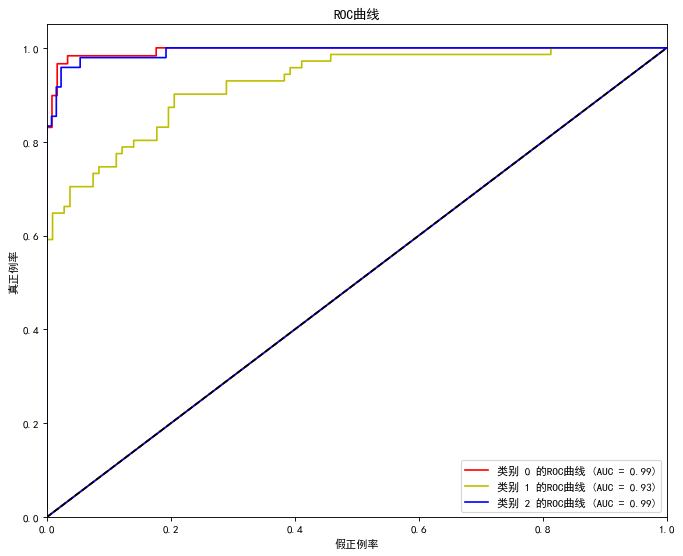

In [9]:
def roc_curve(scores, label):
    # 提取正负样本
    p_s = np.array([score[label] for score in scores if score[3] == label])
    n_s = np.array([score[label] for score in scores if score[3] != label])
    positive_num, negative_num = len(p_s), len(n_s)

    # 计算fpr和tpr
    thresholds = np.unique(np.concatenate([p_s, n_s]))
    fpr = np.zeros(len(thresholds) + 1)
    tpr = np.zeros(len(thresholds) + 1)

    # 计算每一个threshold对应的fpr和tpr
    for i, threshold in enumerate(thresholds):
        fpr[i + 1] = np.sum(n_s >= threshold) / negative_num
        tpr[i + 1] = np.sum(p_s >= threshold) / positive_num

    # 计算AUC
    p_s_expanded = np.tile(p_s, (negative_num, 1)).T
    n_s_expanded = np.tile(n_s, (positive_num, 1))
    auc = np.sum(p_s_expanded > n_s_expanded) + 0.5 * np.sum(p_s_expanded == n_s_expanded)
    auc /= (positive_num * negative_num)

    return fpr, tpr, auc

# 初始化存储每个类别的fpr、tpr和AUC值的列表
fpr = []
tpr = []
auc = []

# 对每个类别计算ROC曲线和AUC值
for i in range(class_num):
    fpr_i, tpr_i, auc_i = roc_curve(y_pred_scores, i)
    fpr.append(fpr_i)
    tpr.append(tpr_i)
    auc.append(auc_i)
    print("第{}类红酒AUC值为{}".format(i, auc_i))

# 绘制ROC曲线
plt.figure(figsize=(10, 8), dpi=80)
colors = ['r', 'y', 'b']
for i, color in zip(range(class_num), colors):
    plt.plot(fpr[i], tpr[i], color=color, label='类别 {} 的ROC曲线 (AUC = {:.2f})'.format(i, auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正例率')
plt.ylabel('真正例率')
plt.title('ROC曲线')
plt.legend(loc="lower right")
plt.show()

AUC（Area Under the Curve）是评估分类模型性能的一种指标，通常用于衡量模型在不同阈值下的假正例率（FPR）和真正例率（TPR）之间的权衡：

1. **第0类红酒AUC值为0.9947：**
   - 该类别的AUC接近于1，表明模型在该类别上的性能非常优秀。
   - 模型对正负样本的区分能力较强，相对较少的假正例和假负例。
   - ROC曲线与对角线的距离较远，说明模型在该类别上的性能可靠。

2. **第1类红酒AUC值为0.9255：**
   - AUC值较高，但相对于第0类别略有降低，可能是由于该类别的样本分布不够均匀或模型在某些情况下性能较差。
   - ROC曲线与对角线的距离适中，模型对正负样本的区分能力较好，但仍有改进空间。

3. **第2类红酒AUC值为0.9928：**
   - 该类别的AUC值非常接近于1，表明模型在该类别上的性能也非常优秀。
   - 模型对正负样本的区分能力非常强，很少出现假正例和假负例。
   - ROC曲线与对角线的距离非常远，说明模型在该类别上的性能非常可靠。

综合来看，模型在三个类别上都表现出色，特别是在第0和第2类别上性能较为出众。

## 拓展要求
浅谈ROC曲线和AUC值作为分类评价的合理性。

**1. ROC曲线：**

**定义：** ROC（Receiver Operating Characteristic）曲线是一种用于评估分类模型性能的图形工具。它以假正例率（FPR）为横轴，真正例率（TPR，又称为灵敏度或召回率）为纵轴，展示了在不同分类阈值下模型的性能。

**合理性：**
- **不受类别不平衡影响：** ROC曲线对于类别不平衡的问题具有较好的鲁棒性，因为它关注的是正负例的比例。
- **可视化性能：** ROC曲线直观地展示了模型在不同阈值下的表现，特别适用于比较多个模型的性能。
- **阈值不敏感：** ROC曲线不依赖于具体的分类阈值，使得评估更加全面，不会受到单一阈值选择的限制。

**2. AUC值：**

**定义：** AUC（Area Under the Curve）是ROC曲线下方的面积，**它的物理意义是：随机选出一对正负样本，模型对正样本的打分大于对负样本打分的概率**。通常用于衡量一个分类模型把真正的正样本排在负样本前面的能力，能力越强则AUC越高。AUC的优点在于不受正负样本分布的影响。

**合理性：**
- **综合性评价：** AUC值综合考虑了不同阈值下模型的性能，对整体分类质量进行了量化评估。
- **不受类别分布影响：** AUC值对于类别不平衡的数据也相对稳健，不会受到极端分布的影响。
- **适用于二分类和多分类：** AUC值不仅适用于二分类问题，而且可以自然地扩展到多分类问题。

**综合评价：**

ROC曲线和AUC值在分类问题中具有很高的合理性，尤其适用于以下情境：
- **类别不平衡：** 当正负样本分布不平衡时，ROC曲线和AUC值能够提供全面的评估，而不受数据分布的影响。
- **多分类问题：** ROC曲线和AUC值不仅适用于二分类问题，而且可以扩展到多分类问题，为多类别的模型性能评估提供了有效的工具。
- **比较模型：** ROC曲线和AUC值能够直观地比较多个模型的性能，帮助选择最优的分类器。